# 変分ベイズ

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from mpl_toolkits.mplot3d import Axes3D
from scipy import genfromtxt
from scipy.special import gamma
%matplotlib inline

eps = np.finfo(float).eps

### ガウス分布の作成

In [2]:
def makeGauss1Dist(mu, sig):
    def func(x):
        y = np.exp(-(x - mu)**2/(2*sig)) / np.sqrt(2*np.pi*sig)
        return y
    return func

def makeGauss2Dist(mu, sig):
    def func(x):
        y = np.exp(-(x-mu).T.dot(np.linalg.inv(sig)).dot(x-mu)/2) / ((2*np.pi)**(2/2)*np.sqrt(np.linalg.det(sig)))
        return y
    return func

### ガンマ分布の作成，及び ガウス-ガンマ分布の作成

In [3]:
def makeGammaDist(a, b):
    def gammaDist(x):
        return b**a*x**(a-1)*np.exp(-b*x) / gamma(a)
    return gammaDist

def gaussGammaDist(tau, mu, a=1, b=1, m=0, l=1):
    pgm = makeGammaDist(a, b)
    pga = makeGauss1Dist(m, (l*tau)**-1) 
    
    return pgm(tau)*pga(mu)

メッシュの準備

In [4]:
m = 100
x = np.linspace(-5, 5, m)
y = np.linspace(-5, 5, m)
xx, yy = np.meshgrid(x, y)

tau = np.linspace(eps, 5, 100)
mu = np.linspace(-5, 5, 100)
tt, mm = np.meshgrid(tau, mu)

# １変数ガウスのベイズ推定

データの分布パラメータ（正規分布）

In [5]:
mu_D, sig_D, N = 2, 9, 10000

平均$\mu$未知， 分散$\sigma^2$既知の正規分布の$\mu$についてのベイズ推定

mu -0.29311360555831634 ==> 1.24400402526 <=> 2
sig 1.7721136430428792 ==> 0.25656608878466924


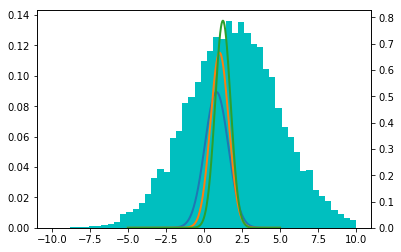

In [6]:
# 見本のサンプル
Xs = np.random.normal(mu_D, sig_D**0.5, N)
fig, ax1 = plt.subplots()
ax1.hist(Xs, bins=np.linspace(-10, 10, 50), normed=True, color="c")  # 見本サンプルのヒストグラム
ax2 = ax1.twinx()

# 事前分布のパラメータ
mu_init, sig_init = np.random.uniform(-5, 5), np.random.uniform(1, 5)**2
Ns = 10  # サンプル数

# 事後分布計算 → 事前分布の更新
mu_prior, sig_prior = mu_init, sig_init
for i in range(3):
    # サンプリング
    Xs = np.random.normal(mu_D, sig_D**0.5, Ns)
    
    # 事後分布計算
    mu_post = sig_D*mu_prior/(Ns*sig_prior+sig_D) + Ns*sig_prior*Xs.mean()/(Ns*sig_prior+sig_D)
    sig_post = (1/sig_prior + Ns/sig_D)**-1
    dist_post = makeGauss1Dist(mu_post, sig_post)
    
    # 事後分布をプロット
    ax2.plot(np.linspace(-5, 5, 1000), dist_post(np.linspace(-5, 5,1000)), linewidth=2)
    
    # 事前分布のパラメータを更新
    mu_prior = mu_post
    sig_prior = sig_post
    
_=ax2.set_ylim(0, )
print("mu", mu_init,  "==>", mu_post, "<=>", mu_D)
print("sig", sig_init,  "==>", sig_post)

平均$\mu$既知， 分散$\sigma^2$未知の正規分布の$\mu$についてのベイズ推定

sig: 8.76573204067 <==> 9


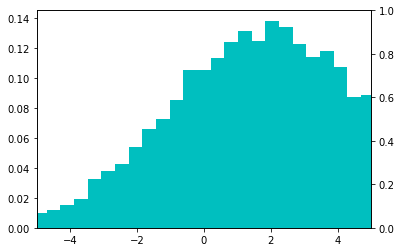

In [7]:
# 見本のサンプル
Xs = np.random.normal(mu_D, sig_D**0.5, N)
fig, ax1 = plt.subplots()
ax1.hist(Xs, bins=np.linspace(-10, 10, 50), normed=True, color="c")  # 見本サンプルのヒストグラム
ax2 = ax1.twinx()

# 事前分布のパラメータ
a_init, b_init = 0, 0  # 無情報事前分布のパラメータ
Ns, n = 50, 50   # サンプル数 and 繰り返し回数

# 事後分布計算 → 事前分布の更新
a_prior, b_prior = a_init, b_init
for i in range(n):
    # サンプリング
    Xs = np.random.normal(mu_D, sig_D**0.5, Ns)
    
    # 事後分布計算
    a_post = a_prior + Ns/2
    b_post = b_prior + Ns*Xs.var()/2;
    dist_post = makeGammaDist(a_post, b_post)
    
    # 事後分布をプロット
    try:
        pass#ax2.plot(np.linspace(eps, 5, 100), dist_post(np.linspace(eps, 5,100)), linewidth=2)
    except:
        a_prior = a_post
        b_prior = b_post
        break
    
    # 事前分布のパラメータを更新
    a_prior = a_post
    b_prior = b_post
    
_=ax2.set_ylim(0, )
_=plt.xlim(-5, 5)

print("sig:", b_post/a_post, "<==>", sig_D)

平均$\mu$未知， 分散$\sigma^2$未知の正規分布の$\mu$についてのベイズ推定

1.66123018081 8.56240757702
1.95017374293 31.2899028193


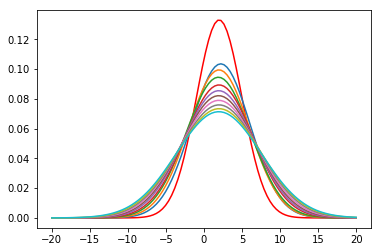

In [8]:

# 事前分布のパラメータ
a_init, b_init, mu_init, l_init = 0,0,np.random.uniform(-5,5),1
Ns, n = 100, 10   # サンプル数 and 繰り返し回数

data_dist = makeGauss1Dist(mu_D, sig_D)
plt.plot(np.linspace(-20, 20, 100), data_dist(np.linspace(-20, 20, 100)), "r")

a_prior, b_prior, mu_prior, l_prior = a_init, b_init, mu_init, l_init
for i in range(n):
    Xs = np.random.normal(mu_D, sig_D**0.5, Ns)
    
    a_post = a_prior + Ns/2
    b_post = ((Xs**2).sum() + l_prior*mu_prior**2) / 2 + b_prior
    mu_post = (Xs.sum() + l_prior*mu_prior) / (Ns + l_prior)
    l_post = Ns + l_prior

    #plt.subplot(122)
    model_dist = makeGauss1Dist(mu_post, b_post/a_post)
    plt.plot(np.linspace(-20, 20, 100), model_dist(np.linspace(-20, 20, 100)), )

    a_prior = a_post
    b_prior = b_post
    mu_prior = mu_post
    l_prior = l_post
    
print(Xs.mean(), Xs.var())
print(mu_post, b_post/a_post)

## 分解による近似(平均場近似)

1次元正規分布の掛け算結果

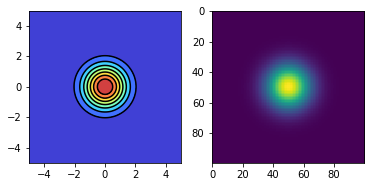

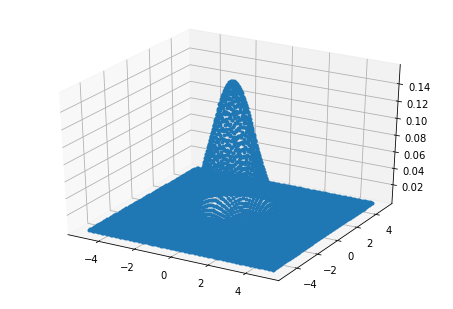

In [9]:
norm1 = makeGauss1Dist(0, 1)
norm2 = makeGauss1Dist(0, 1)
plt.figure(0)
plt.subplot(121)
plt.contourf(xx, yy, norm1(xx)*norm2(yy), 8, alpha=.75, cmap='jet')
plt.contour(xx, yy, norm1(xx)*norm2(yy), 8, colors='black', linewidth=.5)
plt.gca().set_aspect('equal')
plt.subplot(122)
plt.imshow(norm1(xx)*norm2(yy))
# グラフ作成
ax = Axes3D(plt.figure(1))
ax.plot(xx.reshape(m**2), yy.reshape(m**2), (norm1(xx)*norm2(yy)).reshape(m**2), ".")

$q\left( \boldsymbol{z} \right) = \Pi q_i\left( \boldsymbol{z_i} \right)$ として  
2次元正規分布を1次元正規分布の同時確率として近似する．

2次元正規分布の作成

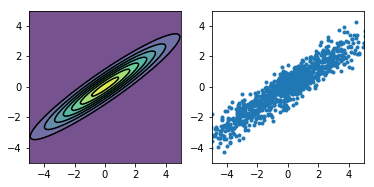

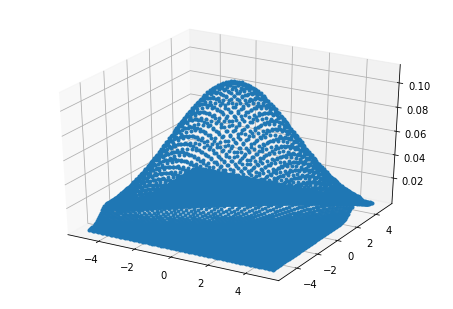

In [10]:
mu = np.array([0, 0]).reshape((2, 1))
sig = np.array([[6, 4], [4, 3]])

norm3 = makeGauss2Dist(mu, sig)
X = np.concatenate([xx.reshape(1, m**2), yy.reshape(1, m**2)], axis=0)
Z = np.array([norm3(xi.reshape(2,1)) for xi in X.T])

plt.figure(0)
plt.subplot(121)
plt.contourf(xx, yy, Z.reshape(m,m), 8, alpha=.75)
plt.contour(xx, yy, Z.reshape(m,m), 8, colors='black', linewidth=.5)
plt.gca().set_aspect('equal')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.savefig("true_contour.png")

plt.subplot(122)
Xs = np.random.multivariate_normal(mu.reshape(2), sig, 1000)
plt.plot(Xs[:,0], Xs[:,1], ".")
plt.gca().set_aspect('equal')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.savefig("sampling.png")

# グラフ作成
ax = Axes3D(plt.figure(1))
ax.plot(xx.reshape(m**2), yy.reshape(m**2), Z.reshape(m**2), ".")

1次元正規分布初期値を作成  
目標との比較

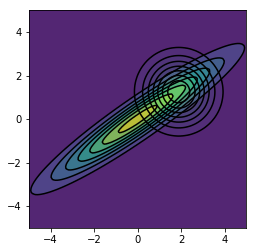

In [11]:
m1, m2 = np.random.uniform(-5, 5, 2)
norm1 = makeGauss1Dist(m1, 1)
norm2 = makeGauss1Dist(m2, 1)
plt.figure(0)
plt.contourf(xx, yy, norm1(xx)*norm2(yy), 8, alpha=.75)
plt.contour(xx, yy, norm1(xx)*norm2(yy), 8, colors='black', linewidth=.5)
plt.contourf(xx, yy, Z.reshape(m,m), 8, alpha=.75)
plt.contour(xx, yy, Z.reshape(m,m), 8, colors='black', linewidth=.5)
plt.gca().set_aspect('equal')

分解した各分布を変分推論の手法によって更新  
最終結果を表示する

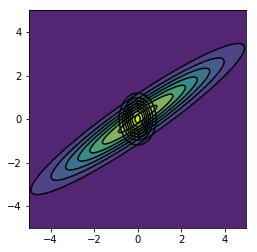

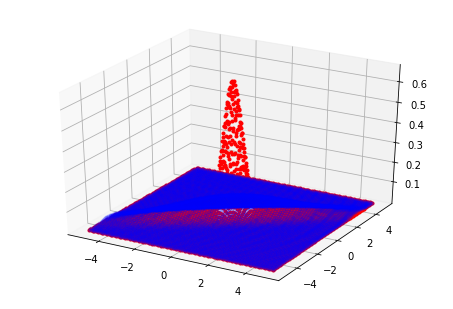

In [12]:
#mu_s, sig_s = np.mean(Xs.T, axis=1), np.cov(Xs.T)
for i in range(50):
    m1 = mu[0] - 1/sig[0,0]*sig[0,1]*(m2 - mu[1])
    norm1 = makeGauss1Dist(m1, 1/sig[0,0])
    m2 = mu[1] - 1/sig[1,1]*sig[0,1]*(m1 - mu[0])
    norm2 = makeGauss1Dist(m2, 1/sig[1,1])

plt.figure(0)
plt.contourf(xx, yy, norm1(xx)*norm2(yy), 10, alpha=.75)
plt.contour(xx, yy, norm1(xx)*norm2(yy), 10, colors='black', linewidth=.5)
plt.contourf(xx, yy, Z.reshape(m,m), 8, alpha=.75)
plt.contour(xx, yy, Z.reshape(m,m), 8, colors='black', linewidth=.5)
plt.gca().set_aspect('equal')

# グラフ作成
ax = Axes3D(plt.figure(2))
ax.plot(xx.reshape(m**2), yy.reshape(m**2), (norm1(xx)*norm2(yy)).reshape(m**2), "r.")
ax.plot(xx.reshape(m**2), yy.reshape(m**2), Z.reshape(m**2), "b.", alpha=0.2)

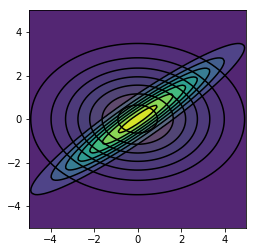

In [13]:
norm1 = makeGauss1Dist(mu[0,0], sig[0,0])
norm2 = makeGauss1Dist(mu[1,0], sig[1,1])
plt.figure(0)
plt.contourf(xx, yy, norm1(xx)*norm2(yy), 8, alpha=.75)
plt.contour(xx, yy, norm1(xx)*norm2(yy), 8, colors='black', linewidth=.5)
plt.contourf(xx, yy, Z.reshape(m,m), 8, alpha=.75)
plt.contour(xx, yy, Z.reshape(m,m), 8, colors='black', linewidth=.5)
plt.gca().set_aspect('equal')

---

## 1変数ガウス

真の事前分布パラメータ

In [14]:
tau = np.linspace(eps, 1, 100)
mu = np.linspace(-2, 2, 100)
tt, mm = np.meshgrid(tau, mu)

In [15]:
mu_D, sig_D = 0, 1.5

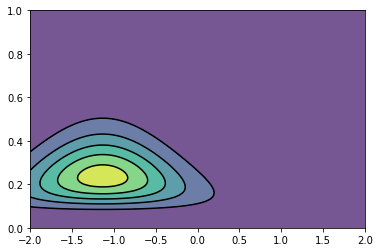

In [16]:
Ns = 10
Xs = np.random.normal(mu_D, sig_D, Ns)
a_t = Ns/2
b_t = (Xs**2).sum() / 2
mu_t = Xs.sum() / Ns
l_t = Ns

plt.contourf(mm, tt, gaussGammaDist(tt, mm, a_t,b_t,mu_t,l_t), 6, alpha=.75)
plt.contour(mm, tt, gaussGammaDist(tt, mm, a_t,b_t,mu_t,l_t), 6, colors='black', linewidth=.5)
#plt.gca().set_aspect('equal')

事後分布の推定パラメータ

事前分布が幾つかサンプリングをしたあとの事後分布の場合

In [17]:
# 事前分布のパラメータ
Np = 5
Xp = np.random.normal(mu_D, sig_D, Np)
a_prior = Np/2
b_prior = (Xp**2).sum() / 2
mu_prior = Xp.sum() / Np
l_prior = Np

In [18]:
# 変分ベイズによる事後分布の計算
Et = 0
for i in range(10):
    if Et == 0: Et = a_prior / b_prior
    else: Et = a_vb1 / b_vb1
    mu_vb1 = (Xs.sum() + mu_prior) / (Ns + l_prior)
    l_vb1 = Et * (Ns + l_prior)
    
    a_vb1 = a_prior + (Ns+1) / 2
    b_vb1 = b_prior + ((Xs**2).sum() + l_prior*mu_prior**2) / 2
    b_vb1 += (Ns + l_prior) * (mu_vb1**2 + l_vb1**-1) / 2
    b_vb1 += - (Xs.sum() + l_prior*mu_prior) * mu_vb1
    
print(mu_D, sig_D, "＝＝＞", mu_vb1, (b_vb1/a_vb1)**0.5)
print(a_vb1, "<==>", a_t)
print(b_vb1, "<==>", b_t)
print(mu_vb1, "<==>", mu_t)
print(l_vb1, "<==>", l_t)


0 1.5 ＝＝＞ -0.79386574822 1.43530611273
8.0 <==> 5.0
16.4808290979 <==> 19.1345156661
-0.79386574822 <==> -1.1345009202
7.2811870864 <==> 10


事前分布が無情報事前分布の場合

In [19]:
# 変分ベイズによる事後分布の計算
Et = 0
for i in range(10):
    if Et == 0: Et = Xs.var()**-1
    else: Et = a_vb2 / b_vb2
    mu_vb2 = Xs.sum()/Ns
    l_vb2 = Et * Ns
    
    a_vb2 = (Ns+1) / 2
    b_vb2 = (Xs**2).sum() / 2
    b_vb2 += Ns * (mu_vb2**2 + l_vb2**-1) / 2
    b_vb2 += -Xs.sum() * mu_vb2
    
print(mu_D, sig_D, "＝＝＞", mu_vb2, (b_vb2/a_vb2)**0.5)
print(a_vb2, "<==>", a_t)
print(b_vb2, "<==>", b_t)
print(mu_vb2, "<==>", mu_t)
print(l_vb2, "<==>", l_t)

0 1.5 ＝＝＞ -1.1345009202 1.59367838515
5.5 <==> 5.0
13.9689593741 <==> 19.1345156661
-1.1345009202 <==> -1.1345009202
3.93730116374 <==> 10


結果の比較  
左：事前分布が無情報で無い  
右：事前分布が無情報事前分布

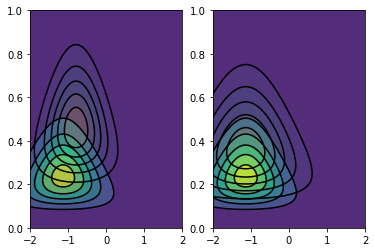

In [20]:
plt.subplot(121)
plt.contourf(mm, tt, gaussGammaDist(tt, mm, a_vb1,b_vb1,mu_vb1,l_vb1), 6, alpha=.75)
plt.contour(mm, tt, gaussGammaDist(tt, mm, a_vb1,b_vb1,mu_vb1,l_vb1), 6, colors='black', linewidth=.5)
#plt.gca().set_aspect('equal')

plt.contourf(mm, tt, gaussGammaDist(tt, mm, a_t,b_t,mu_t,l_t), 6, alpha=.75)
plt.contour(mm, tt, gaussGammaDist(tt, mm, a_t,b_t,mu_t,l_t), 6, colors='black', linewidth=.5)
#plt.gca().set_aspect('equal')

plt.subplot(122)
plt.contourf(mm, tt, gaussGammaDist(tt, mm, a_vb2,b_vb2,mu_vb2,l_vb2), 6, alpha=.75)
plt.contour(mm, tt, gaussGammaDist(tt, mm, a_vb2,b_vb2,mu_vb2,l_vb2), 6, colors='black', linewidth=.5)
#plt.gca().set_aspect('equal')

plt.contourf(mm, tt, gaussGammaDist(tt, mm, a_t,b_t,mu_t,l_t), 6, alpha=.75)
plt.contour(mm, tt, gaussGammaDist(tt, mm, a_t,b_t,mu_t,l_t), 6, colors='black', linewidth=.5)
#plt.gca().set_aspect('equal')

事前分布が無情報事前分布でないとき，初期状態から各ステップでの更新の様子をプロット

0 1.5 ＝＝＞ -0.705897612095 1.74227356769
8.0 <==> 5.0
24.2841374774 <==> 19.1345156661
-0.705897612095 <==> -1.1345009202
4.94149730919 <==> 10


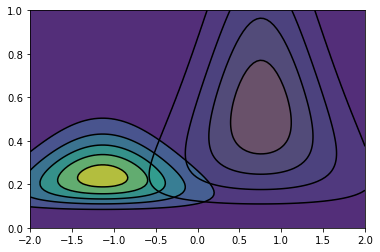

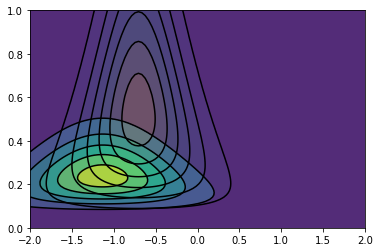

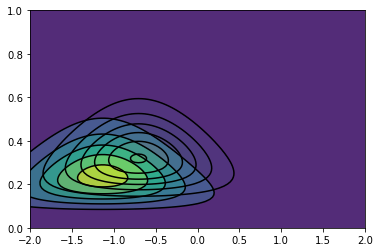

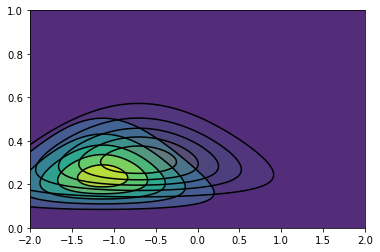

In [21]:
Et = 0
Np = 5
Xp = np.random.normal(mu_D, sig_D, Np)
a_prior = Np/2
b_prior = (Xp**2).sum() / 2
mu_prior = Xp.sum() / Np
l_prior = Np

#plt.subplot(221)
plt.figure(0)
plt.contourf(mm, tt, gaussGammaDist(tt, mm, a_prior,b_prior,mu_prior,l_prior), 6, alpha=.75)
plt.contour(mm, tt, gaussGammaDist(tt, mm, a_prior,b_prior,mu_prior,l_prior), 6, colors='black', linewidth=.5)
#plt.gca().set_aspect('equal')

plt.contourf(mm, tt, gaussGammaDist(tt, mm, a_t,b_t,mu_t,l_t), 6, alpha=.75)
plt.contour(mm, tt, gaussGammaDist(tt, mm, a_t,b_t,mu_t,l_t), 6, colors='black', linewidth=.5)
#plt.gca().set_aspect('equal')

for i in range(10):
    if Et == 0: Et = a_prior / b_prior
    else: Et = a_vb1 / b_vb1
    mu_vb1 = (Xs.sum() + mu_prior) / (Ns + l_prior)
    l_vb1 = Et * (Ns + l_prior)
    if i == 0:
        #plt.subplot(222)
        plt.figure(1)
        plt.contourf(mm, tt, gaussGammaDist(tt, mm, a_prior,b_prior,mu_vb1, l_vb1), 6, alpha=.75)
        plt.contour(mm, tt, gaussGammaDist(tt, mm, a_prior,b_prior,mu_vb1,l_vb1), 6, colors='black', linewidth=.5)
        #plt.gca().set_aspect('equal')

        plt.contourf(mm, tt, gaussGammaDist(tt, mm, a_t,b_t,mu_t,l_t), 6, alpha=.75)
        plt.contour(mm, tt, gaussGammaDist(tt, mm, a_t,b_t,mu_t,l_t), 6, colors='black', linewidth=.5)
        #plt.gca().set_aspect('equal')

    a_vb1 = a_prior + (Ns+1) / 2
    b_vb1 = b_prior + ((Xs**2).sum() + l_prior*mu_prior**2) / 2
    b_vb1 += (Ns + l_prior) * (mu_vb1**2 + l_vb1**-1) / 2
    b_vb1 += - (Xs.sum() + l_prior*mu_prior) * mu_vb1
    if i == 0:
        #plt.subplot(223)
        plt.figure(2)
        plt.contourf(mm, tt, gaussGammaDist(tt, mm, a_vb1, b_vb1,mu_vb1, l_vb1), 6, alpha=.75)
        plt.contour(mm, tt, gaussGammaDist(tt, mm, a_vb1,b_vb1,mu_vb1,l_vb1), 6, colors='black', linewidth=.5)
        #plt.gca().set_aspect('equal')

        plt.contourf(mm, tt, gaussGammaDist(tt, mm, a_t,b_t,mu_t,l_t), 6, alpha=.75)
        plt.contour(mm, tt, gaussGammaDist(tt, mm, a_t,b_t,mu_t,l_t), 6, colors='black', linewidth=.5)
        #plt.gca().set_aspect('equal')
    


#plt.subplot(224)
plt.figure(3)
plt.contourf(mm, tt, gaussGammaDist(tt, mm, a_vb1, b_vb1,mu_vb1, l_vb1), 6, alpha=.75)
plt.contour(mm, tt, gaussGammaDist(tt, mm, a_vb1,b_vb1,mu_vb1,l_vb1), 6, colors='black', linewidth=.5)
#plt.gca().set_aspect('equal')

plt.contourf(mm, tt, gaussGammaDist(tt, mm, a_t,b_t,mu_t,l_t), 6, alpha=.75)
plt.contour(mm, tt, gaussGammaDist(tt, mm, a_t,b_t,mu_t,l_t), 6, colors='black', linewidth=.5)
#plt.gca().set_aspect('equal')
print(mu_D, sig_D, "＝＝＞", mu_vb1, (b_vb1/a_vb1)**0.5)
print(a_vb1, "<==>", a_t)
print(b_vb1, "<==>", b_t)
print(mu_vb1, "<==>", mu_t)
print(l_vb1, "<==>", l_t)